In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from model import build_tokenizer, get_model, preload_model
from config import get_config, latest_weights_file_path
from utils import set_up_device
from dataset import get_eval_dataloader
from transformers.modeling_outputs import CausalLMOutputWithPast


In [8]:
## Get model and tokenizer
config = get_config()
tokenizer = build_tokenizer() # This method will call the model.py file. The tokenizer is configured there
model = get_model(tokenizer, config['vocab_size'], config['hidden_size'], config['num_hidden_layers'], config['intermediate_size'], config['num_attention_heads'], config['max_position_embeddings']) # This will need to be updated when we know what parameters our model will use.
optimizer_constructors = {
    "adam": lambda: torch.optim.Adam(model.parameters(), lr=config['top_lr'], eps=1e-8),
    "sgd": lambda: torch.optim.SGD(model.parameters(), lr=config['top_lr'], momentum=0.9)
}
optimizer = optimizer_constructors[config['optimizer']]()
device = set_up_device()
model_filename = latest_weights_file_path(config, config['model_basename'])
model, _, optimizer, _ = preload_model(model_filename, model, optimizer, device)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Model total params: 36776960
Using device:  cpu
Preloading model trained_fot_weights\fotmodel380.pt


In [25]:
def visualize_attention_one_token(attention_weights, input_, token_name=""):
    """Visualize attention from one token to other tokens for each head."""
    tokens = input_["src_smiles"][0]    
    num_tokens = len(tokens)
    fig, ax = plt.subplots(figsize=(5, len(tokens) / 5))
    # We remove the padding tokens from the attention weights.
    attention_weights = attention_weights[:, :num_tokens]
    attention_weights = attention_weights.cpu().numpy()
    cmap = sns.heatmap(attention_weights.T, cmap="Reds", yticklabels=tokens)
    plt.title(f"Attention weights for {token_name}")
    plt.xlabel("Head index")
    plt.show()


def visualize_attention_map(attention_weights, input_, title=""):
    """Visualize attention between all tokens."""
    tokens = input_["src_smiles"][0]
    num_tokens = len(tokens)
    fig, ax = plt.subplots(figsize=(len(tokens) / 5, len(tokens) / 5))
    # We remove the padding tokens from the attention weights.
    attention_weights = attention_weights[:num_tokens, :num_tokens]
    attention_weights = attention_weights.cpu().numpy()
    cmap = sns.heatmap(
        attention_weights.T, cmap="Reds", yticklabels=tokens, xticklabels=tokens,
    )
    plt.ylabel("Queries")
    plt.xlabel("Keys")
    plt.title(title)
    plt.show()


def create_attention_plots(
    model, input, lvl_idx=-1, head_idx=0, attn_key="bert_attn", token="C"
):
    """Create attention plots."""
    # Create attention plots for all tokens in input.
    pred:CausalLMOutputWithPast = model(input['src_input'], output_attentions = True)
    concatenated_tensor = torch.cat(pred.attentions, dim=0) 
    print("SHAPE",concatenated_tensor.shape)
    # Reshape the concatenated tensor
    attention_weights = concatenated_tensor.view(5, 8, 200, 200)
    
    # Visualize attention from CLS token to other tokens for each head.
    if attn_key == "transformer_attn":
        attention_from_cls_token = attention_weights[:, lvl_idx, :, 0]
    elif attn_key == "bert_attn":
        # Bert attention weights are stored in a different format.
        attention_from_cls_token = attention_weights[lvl_idx, :, 0, :]
    else:
        raise ValueError(f"Unknown attention key: {attn_key}")

    #visualize_attention_one_token(attention_from_cls_token, input, token)

    # Visualize attention between all tokens.
    if attn_key == "transformer_attn":
        attention_weights_head = attention_weights[head_idx, lvl_idx]
    elif attn_key == "bert_attn":
        # Bert attention weights are stored in a different format.
        attention_weights_head = attention_weights[lvl_idx, head_idx].T
    else:
        raise ValueError(f"Unknown attention key: {attn_key}")

    title = f"Attention weights for head {head_idx}"
    visualize_attention_map(attention_weights_head, input, title)


def text_to_tensor(text, tokenizer):
    """Convert text to tensor."""
    encoded_input = tokenizer(text, truncation=True)
    return encoded_input


In [16]:
def top_k_sampling(logits, k=10):
    top_k = torch.topk(logits, k)
    top_k_indices = top_k.indices
    top_k_values = top_k.values
    probabilities = torch.softmax(top_k_values, dim=-1)
    choice = torch.multinomial(probabilities, num_samples=1)
    token_id = int(top_k_indices[choice])
    return token_id

def top_k_generation(model, data, tokenizer, max_len, device):
    print(data['src_smiles'])
    input_ids = tokenizer.encode(data['src_smiles'][0])
    output_token_ids = list([])

    #input_ids = input_ids[-max_len:]
    with torch.no_grad():
        for i in range(max_len):
            if(i == 0):
                out = model(torch.as_tensor([input_ids]), use_cache=True)
                logits = out.logits
                past_key_values = out.past_key_values
            else:
                out = model(torch.as_tensor([[token_id]]), use_cache=True, past_key_values = past_key_values)        
                logits = out.logits
                past_key_values = out.past_key_values
            
            last_token_logits = logits[0][-1]
            token_id = top_k_sampling(last_token_logits)
            output_token_ids.append(token_id)
            
            if(token_id == tokenizer.eos_token_id):
                break
    return tokenizer.decode(output_token_ids, skip_special_tokens=True)

## following section covers plotting of heatmaps given an input sequence and its target

In [17]:
# Get a batch of data
data, eval_dataloader = get_eval_dataloader(tokenizer, 'test/metabolic_smiles', config['seq_len']) # This method will call a function in dataset.py which will load the data in the desired format
batch = next(iter(eval_dataloader))

Max length of source sentence: 128
Max length of target sentence: 105


Outputing attentions is not supported in LongLlamaForCausalLM and LongLlamaForSequenceClassification. Attention of the last window will be returned


['CCCCCC1=CC(O)=C2C(=C1)OC(C)(C)C1CC=C(C=O)CC21']
--------------------------------------------------------------------------------
Input:      CCCCCC1=CC(O)=C2C(=C1)OC(C)(C)C1CC=C(C=O)CC21
Generated:  CCC1C1OC
Target:     CCCCCC1=CC(O)=C2C(=C1)OC(C)(C)C1CC=C(C(=O)O)CC21
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
The shape of the past key values
5
6
torch.Size([1, 8, 200, 128])
--------------------------------------------------------------------------------
SHAPE torch.Size([5, 8, 200, 200])


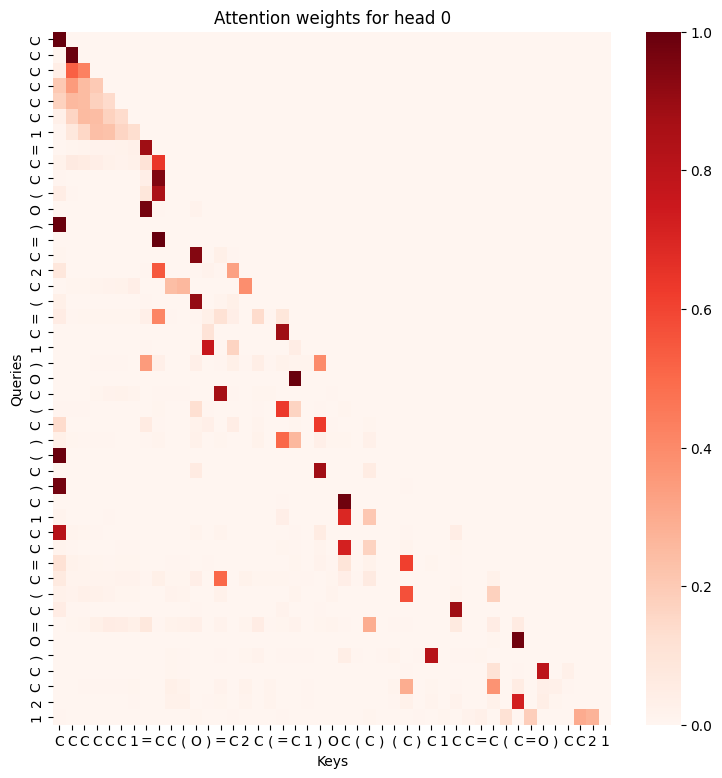

In [26]:
# Use to plot a heatmap of relations between tokens in a particular hidden layer and attention head.

with torch.no_grad():
    labels = batch['label']
    model_output:CausalLMOutputWithPast = model(batch['src_input'])
    generated_seq =  top_k_generation(model, batch, tokenizer, config['seq_len'], device)
    
    print("-"*80)
    print("Input:     ",batch['src_smiles'][0])
    print("Generated: ",generated_seq)
    print("Target:    ",batch['tgt_smiles'][0])
    print("-"*80)

    
    print("-"*80)
    print("The shape of the past key values")
    print(len(model_output.past_key_values))
    print(len(model_output.past_key_values[0]))
    print(model_output.past_key_values[0][0].shape)
    print("-"*80)
    '''
    loss_outputs = model_output.logits.view(-1, model.config.vocab_size)  
    loss_labels = labels.view(-1)
    print(loss_outputs.shape)
    print(loss_labels.shape)
    loss = loss_fn(loss_outputs,loss_labels)
    '''
    # Plots an input sequence and highligts relations between tokens.
    ## Inputs a batch of size 1
    ## head_idx = What head within the attention layer we want to highlight
    ## hidden_layer = What attentionlayer we want to highlight
    create_attention_plots(model, batch, lvl_idx=0, head_idx=0, token="=")

## Following section covers plotting of relevant logs. 
### At the moment the plots made cover the Train loss from dbug runs. These runs were made with the unique_parents dataset

C:\Users\kzbj345\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3550: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


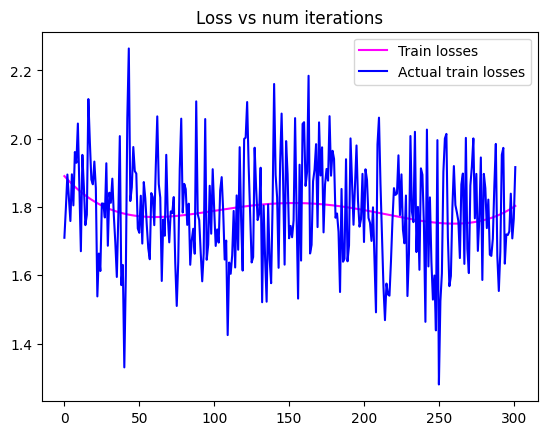

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
learning_rates = pd.read_csv('data/learning_rates/fotmodel.csv')
train_losses = pd.read_csv('data/train_losses/fotmodel.csv')
val_losses = pd.read_csv('data/val_losses/fotmodel.csv')
val_similarities = pd.read_csv('data/val_similarities/fotmodel.csv')

#learning_rates = learning_rates['learning_rates'].tolist()
train_losses = train_losses['train_losses'].tolist()
val_losses = val_losses['val_losses']
#val_similarities = val_similarities['val_similarities']

#learning_rates_x = np.arange(0,len(learning_rates))
#learning_rates_poly = np.poly1d(np.polyfit(x, learning_rates,4))

train_losses_x = np.arange(0,len(train_losses))
train_losses_poly = np.poly1d(np.polyfit(train_losses_x, train_losses,4))

val_losses_x = np.arange(0,len(val_losses))
val_losses_poly = np.poly1d(np.polyfit(val_losses_x, val_losses,3))

#val_similarities_x = np.arange(0,len(val_similarities))
#val_similarities_poly = np.poly1d(np.polyfit(val_similarities_x, val_similarities,3))

#plt.plot(learning_rates_x, learning_rates_poly(learning_rates_x),c="#00ff00", label="Learning rates")
plt.plot(train_losses_x, train_losses_poly(train_losses_x),c="#ff00ff", label="Train losses")
plt.plot(train_losses_x, train_losses,c="#0000ff", label="Actual train losses")
#plt.plot(val_losses_x, val_losses_poly(val_losses_x),c="#ffff00", label="Val losses")
#plt.plot(val_losses_x, val_losses,c="#ff0000", label="Val losses")
#plt.plot(val_similarities_x, val_similarities_poly(val_similarities_x),c="#ffff00", label="Val similarities")
plt.title("Loss vs num iterations")
plt.legend()
plt.show()

In [27]:
loss_changes_df = pd.read_csv('data/fot_metxbiodb_unique_debug_lower_seq_len_pad_last__losses.csv')
loss_no_changes_df = pd.read_csv('data/fot_metxbiodb_unique_debug_no_changes_losses.csv')
loss_changes_nomask_padlast_df = pd.read_csv('data/fot_metxbiodb_unique_debug_pad_last_no_mask__losses.csv')
loss_changes_withscheduler_df = pd.read_csv('data/fot_metxbiodb_unique_debug_pad_last_withscheduler__losses.csv')
loss_changes_withscheduler_withmask_df = pd.read_csv('data/fot_metxbiodb_unique_debug_pad_last_withscheduler_withmask__losses.csv')


changes_y = loss_changes_df['train_losses'].tolist()
no_changes_y = loss_no_changes_df['train_losses'].tolist()
changes_nomask_padlast_y = loss_changes_nomask_padlast_df['train_losses']
loss_changes_withscheduler_y = loss_changes_withscheduler_df['train_losses']
loss_changes_withscheduler_withmask_y = loss_changes_withscheduler_withmask_df['train_losses']

x = np.arange(0,len(no_changes_y))

changes_poly = np.poly1d(np.polyfit(x, changes_y,4))
no_changes_poly = np.poly1d(np.polyfit(x, no_changes_y,4))
changes_nomask_padlast_poly = np.poly1d(np.polyfit(x, changes_nomask_padlast_y,3))
changes_withscheduler_poly = np.poly1d(np.polyfit(x, loss_changes_withscheduler_y,3))
changes_withscheduler_withmask_poly = np.poly1d(np.polyfit(x, loss_changes_withscheduler_withmask_y,3))

#fig, (ax1,ax2) = plt.subplots(1, 2)
#ax1.plot(x,no_changes_poly(x) )
#ax1.set_title("No changes")

#ax2.plot(x, changes_poly(x),c="red")
#ax2.set_title("With changes")

#plt.plot(x, no_changes_y,'x',c="#000055")
#plt.plot(x, changes_y,'x',c="#005500")
#plt.plot(x, changes_nomask_padlast_y,'x',c="#550000")
#plt.plot(x, loss_changes_withscheduler_y,'x',c="#550000")

plt.plot(x, changes_poly(x),c="#00ff00", label="With changes curve")
plt.plot(x, no_changes_poly(x),c="#0000ff", label="No changes curve")
plt.plot(x, changes_nomask_padlast_poly(x),c="#ff0000", label="No mask pad last curve")
plt.plot(x, changes_withscheduler_poly(x),c="#ffff00", label="With scheduler at 750")
plt.plot(x, changes_withscheduler_withmask_poly(x),c="#ff00ff", label="With scheduler at 750 and mask")
plt.title("Loss vs num iterations")
plt.xlabel("Number of iterations  (num_batch*num_epoch)")
plt.ylabel("Calculated loss")
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/fot_metxbiodb_unique_debug_lower_seq_len_pad_last__losses.csv'

In [28]:
train_loss_df = pd.read_csv('data/train_losses/fot_tuned_metabolic_sgd_exponential_.csv')
val_loss_df = pd.read_csv('data/val_losses/fot_tuned_metabolic_sgd_exponential_.csv')

train_y = train_loss_df['train_losses']
val_y = val_loss_df['val_losses']

train_y_average = []
for i in range(0, len(train_y), 350):
    # Take a slice of 350 values
    slice_values = train_y[i:i+350]
    
    # Calculate the average of the slice and append it to the new list
    average = sum(slice_values) / len(slice_values)
    train_y_average.append(average)

train_x = np.arange(0,len(train_y_average))
val_x = np.arange(0,len(val_y))

train_poly = np.poly1d(np.polyfit(train_x, train_y_average,4))
val_poly = np.poly1d(np.polyfit(val_x, val_y,4))

plt.plot(train_x, train_poly(train_x),c="#0000ff", label="Train loss")
plt.plot(val_x, val_poly(val_x),c="#ff0000", label="Val loss")

plt.title("Loss vs num iterations")
plt.xlabel("Number of epochs")
plt.ylabel("Calculated loss")
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/train_losses/fot_tuned_metabolic_sgd_exponential_.csv'

## Final five training runs

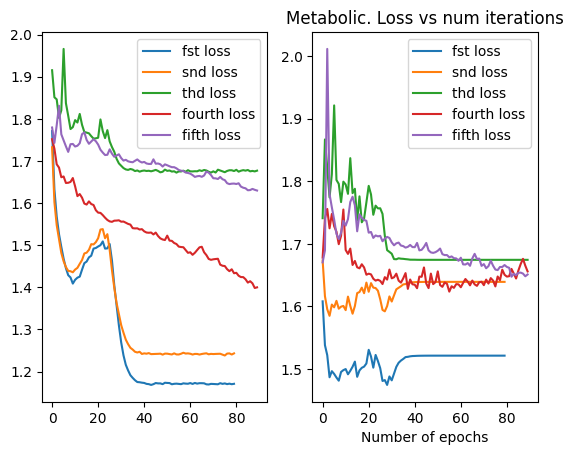

In [20]:
## FIRST: METABOLIC

fig, (ax1,ax2) = plt.subplots(1,2)



# FST
fst_train_loss_df = pd.read_csv('data/top_five_models/train/fotmodel_first_config_metabolic.csv')
fst_val_loss_df = pd.read_csv('data/top_five_models/val/fotmodel_first_config_metabolic.csv')
fst_train_y = fst_train_loss_df['train_losses']
fst_val_y = fst_val_loss_df['val_losses']
fst_x = np.arange(0,len(fst_train_y))
ax1.plot(fst_x, fst_train_y, label="fst loss")
ax2.plot(fst_x, fst_val_y, label="fst loss")
# SND
snd_train_loss_df = pd.read_csv('data/top_five_models/train/fotmodel_second_config_metabolic.csv')
snd_val_loss_df = pd.read_csv('data/top_five_models/val/fotmodel_second_config_metabolic.csv')
snd_train_y = snd_train_loss_df['train_losses']
snd_val_y = snd_val_loss_df['val_losses']
snd_x = np.arange(0,len(snd_train_y))
ax1.plot(snd_x, snd_train_y, label="snd loss")
ax2.plot(snd_x, snd_val_y, label="snd loss")
# THD
thd_train_loss_df = pd.read_csv('data/top_five_models/train/fotmodel_third_config_metabolic.csv')
thd_val_loss_df = pd.read_csv('data/top_five_models/val/fotmodel_third_config_metabolic.csv')
thd_train_y = thd_train_loss_df['train_losses']
thd_val_y = thd_val_loss_df['val_losses']
thd_x = np.arange(0,len(thd_train_y))
ax1.plot(thd_x, thd_train_y, label="thd loss")
ax2.plot(thd_x, thd_val_y, label="thd loss")
# FOURTH
fourth_train_loss_df = pd.read_csv('data/top_five_models/train/fotmodel_fourth_config_metabolic.csv')
fourth_val_loss_df = pd.read_csv('data/top_five_models/val/fotmodel_fourth_config_metabolic.csv')
fourth_train_y = fourth_train_loss_df['train_losses']
fourth_val_y = fourth_val_loss_df['val_losses']
fourth_x = np.arange(0,len(fourth_train_y))
ax1.plot(fourth_x, fourth_train_y, label="fourth loss")
ax2.plot(fourth_x, fourth_val_y, label="fourth loss")
# FIFTH
fifth_train_loss_df = pd.read_csv('data/top_five_models/train/fotmodel_fifth_config_metabolic.csv')
fifth_val_loss_df = pd.read_csv('data/top_five_models/val/fotmodel_fifth_config_metabolic.csv')
fifth_train_y = fifth_train_loss_df['train_losses']
fifth_val_y = fifth_val_loss_df['val_losses']
fifth_x = np.arange(0,len(fifth_train_y))
ax1.plot(fifth_x, fifth_train_y, label="fifth loss")
ax2.plot(fifth_x, fifth_val_y, label="fifth loss")

plt.title("Metabolic. Loss vs num iterations")
plt.xlabel("Number of epochs")
ax1.legend()
ax2.legend()
plt.show()

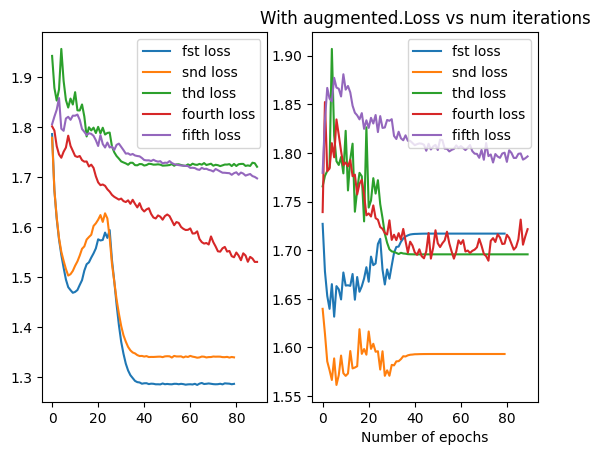

In [23]:
## FIRST: Augmented

fig, (ax1,ax2) = plt.subplots(1,2)

# FST
fst_train_loss_df = pd.read_csv('data/top_five_models/train/fotmodel_first_config_augmented.csv')
fst_val_loss_df = pd.read_csv('data/top_five_models/val/fotmodel_first_config_augmented.csv')
fst_train_y = fst_train_loss_df['train_losses']
fst_val_y = fst_val_loss_df['val_losses']
fst_x = np.arange(0,len(fst_train_y))
ax1.plot(fst_x, fst_train_y, label="fst loss")
ax2.plot(fst_x, fst_val_y, label="fst loss")
# SND
snd_train_loss_df = pd.read_csv('data/top_five_models/train/fotmodel_second_config_augmented.csv')
snd_val_loss_df = pd.read_csv('data/top_five_models/val/fotmodel_second_config_augmented.csv')
snd_train_y = snd_train_loss_df['train_losses']
snd_val_y = snd_val_loss_df['val_losses']
snd_x = np.arange(0,len(snd_train_y))
ax1.plot(snd_x, snd_train_y, label="snd loss")
ax2.plot(snd_x, snd_val_y, label="snd loss")
# THD
thd_train_loss_df = pd.read_csv('data/top_five_models/train/fotmodel_third_config_augmented.csv')
thd_val_loss_df = pd.read_csv('data/top_five_models/val/fotmodel_third_config_augmented.csv')
thd_train_y = thd_train_loss_df['train_losses']
thd_val_y = thd_val_loss_df['val_losses']
thd_x = np.arange(0,len(thd_train_y))
ax1.plot(thd_x, thd_train_y, label="thd loss")
ax2.plot(thd_x, thd_val_y, label="thd loss")
# FOURTH
fourth_train_loss_df = pd.read_csv('data/top_five_models/train/fotmodel_fourth_config_augmented.csv')
fourth_val_loss_df = pd.read_csv('data/top_five_models/val/fotmodel_fourth_config_augmented.csv')
fourth_train_y = fourth_train_loss_df['train_losses']
fourth_val_y = fourth_val_loss_df['val_losses']
fourth_x = np.arange(0,len(fourth_train_y))
ax1.plot(fourth_x, fourth_train_y, label="fourth loss")
ax2.plot(fourth_x, fourth_val_y, label="fourth loss")
# FIFTH
fifth_train_loss_df = pd.read_csv('data/top_five_models/train/fotmodel_fifth_config_augmented.csv')
fifth_val_loss_df = pd.read_csv('data/top_five_models/val/fotmodel_fifth_config_augmented.csv')
fifth_train_y = fifth_train_loss_df['train_losses']
fifth_val_y = fifth_val_loss_df['val_losses']
fifth_x = np.arange(0,len(fifth_train_y))
ax1.plot(fifth_x, fifth_train_y, label="fifth loss")
ax2.plot(fifth_x, fifth_val_y, label="fifth loss")

plt.title("With augmented.Loss vs num iterations")
plt.xlabel("Number of epochs")
ax1.legend()
ax2.legend()
plt.show()

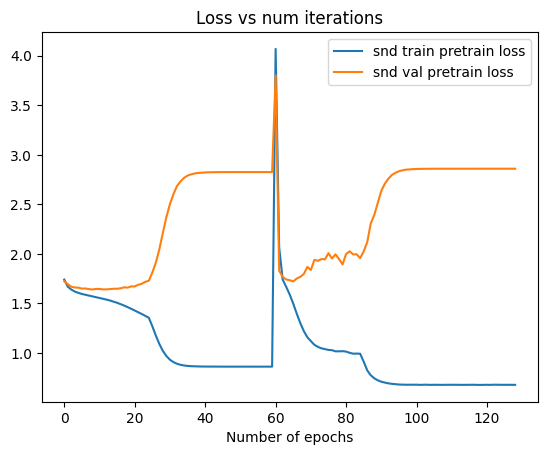

In [25]:
## Config 2 (snd): pretrain

snd_train_loss_df = pd.read_csv('data/top_two_pretrained/train/fotmodel_second_config.csv')
snd_val_loss_df = pd.read_csv('data/top_two_pretrained/val/fotmodel_second_config.csv')
snd_train_y = snd_train_loss_df['train_losses']
snd_val_y = snd_val_loss_df['val_losses']
snd_x = np.arange(0,len(snd_train_y))
plt.plot(snd_x, snd_train_y, label="snd train pretrain loss")
plt.plot(snd_x, snd_val_y, label="snd val pretrain loss")

plt.title("Loss vs num iterations")
plt.xlabel("Number of epochs")
plt.legend()

plt.show()

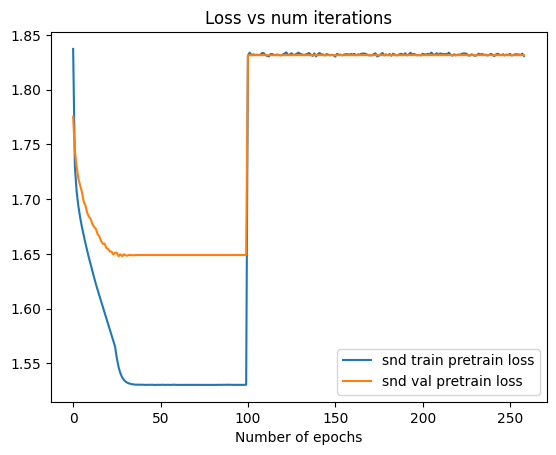

In [26]:
## Config 2 (snd): pretrain

snd_train_loss_df = pd.read_csv('data/top_two_pretrained/train/fotmodel_please_work_.csv')
snd_val_loss_df = pd.read_csv('data/top_two_pretrained/val/fotmodel_please_work_.csv')
snd_train_y = snd_train_loss_df['train_losses']
snd_val_y = snd_val_loss_df['val_losses']
snd_x = np.arange(0,len(snd_train_y))
plt.plot(snd_x, snd_train_y, label="snd train pretrain loss")
plt.plot(snd_x, snd_val_y, label="snd val pretrain loss")

plt.title("Loss vs num iterations")
plt.xlabel("Number of epochs")
plt.legend()

plt.show()